# Decomposition of isometric synthetic HDsEMG signals

In [1]:
%load_ext autoreload
%autoreload 2

import logging
import os

import numpy as np
import torch

import emgkit
from data_utils import load_synthetic_signal

logging.basicConfig(level=logging.INFO)

if torch.cuda.is_available():
    device = torch.device("cuda:0")
    logging.info("Using CUDA version")
else:
    device = torch.device("cpu")
    logging.info("Using CPU version")

SEED = 42
DATA_PATH = os.path.join("data", "synthetic_signals")
MVC = 10
SNR = 10

INFO:root:Using CUDA version


(6, 99201)


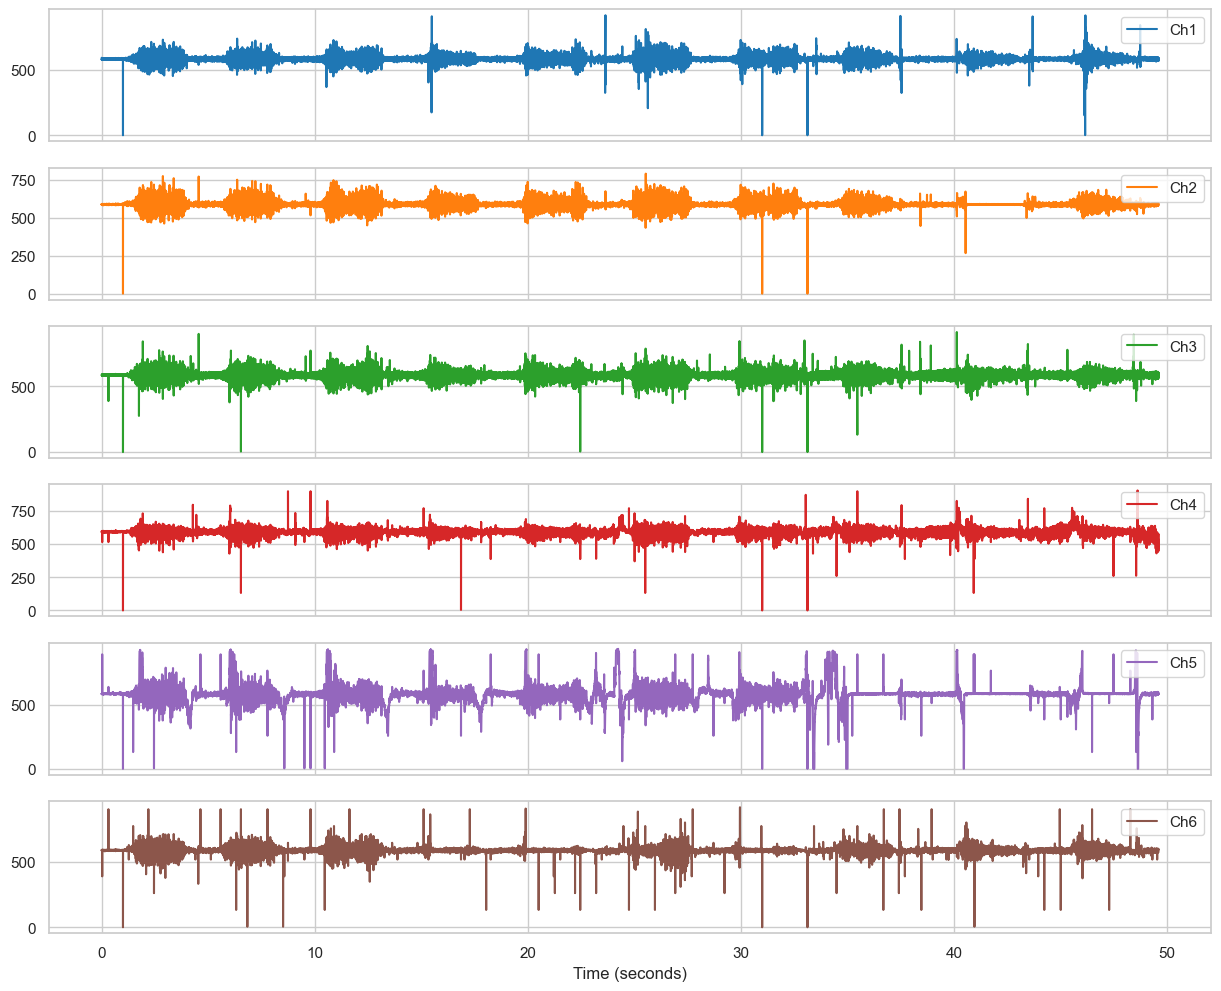

In [2]:
DATA_DIR = u"C:\\Users\\Link\\OneDrive\\Work\\杂任务\\表面肌电\\六通道数据0829"
SUBJECT_TYPE = "1"
SENSOR_TYPE = ""
FS = 2000
SEED = 42

# from adaptive_bss_semg import *

import pandas as pd
import numpy as np
import os 

def load_data(root: str, subject_type: str, sensor_type: str) -> np.ndarray:
    # assert subject_type in ("sound", "patient1"), 'Subject id must be either "sound" or "patient1".'
    # assert sensor_type in ("stretchable_Au", "commercial_Ag"), 'Subject id must be either "stretchable_Au" or "commercial_Ag".'
    # 读取CSV文件
    data = pd.read_csv(os.path.join(root, f"0829六通道({subject_type}).csv"))
    # 确保所有必要的通道都存在
    channel_names = ['CH1', 'CH2', 'CH3', 'CH4', 'CH5', 'CH6']
    for channel in channel_names:
        if channel not in data.columns:
            raise ValueError(f"Missing channel {channel} in the file.")
    
    # 提取通道数据并转换为NumPy数组
    channel_data = np.array([data[channel].values for channel in channel_names])
    
    return channel_data

# 使用函数的例子

channel_array = load_data(DATA_DIR, SUBJECT_TYPE, SENSOR_TYPE)
print(channel_array.shape)

# Load NeuroKit and other useful packages
import neurokit2 as nk
import numpy as np
import pandas as pd
import seaborn as sns
# Visualize
emg_df = pd.DataFrame({"Ch1": channel_array[0],
                       "Ch2": channel_array[1],
                       "Ch3": channel_array[2],
                       "Ch4": channel_array[3],
                       "Ch5": channel_array[4],
                       "Ch6": channel_array[5],
                       })

kwargs = {
    'title': f"Raw sEMG signal ({SUBJECT_TYPE})",
    'y_label': "Amplitude [\u03BCV]",
    'fig_size': (8, 14)
}
# plt.figure(figsize=(8, 19))
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (15, 12)  # 设置默认图形大小
nk.signal_plot(emg_df, sampling_rate=2000,subplots=True)

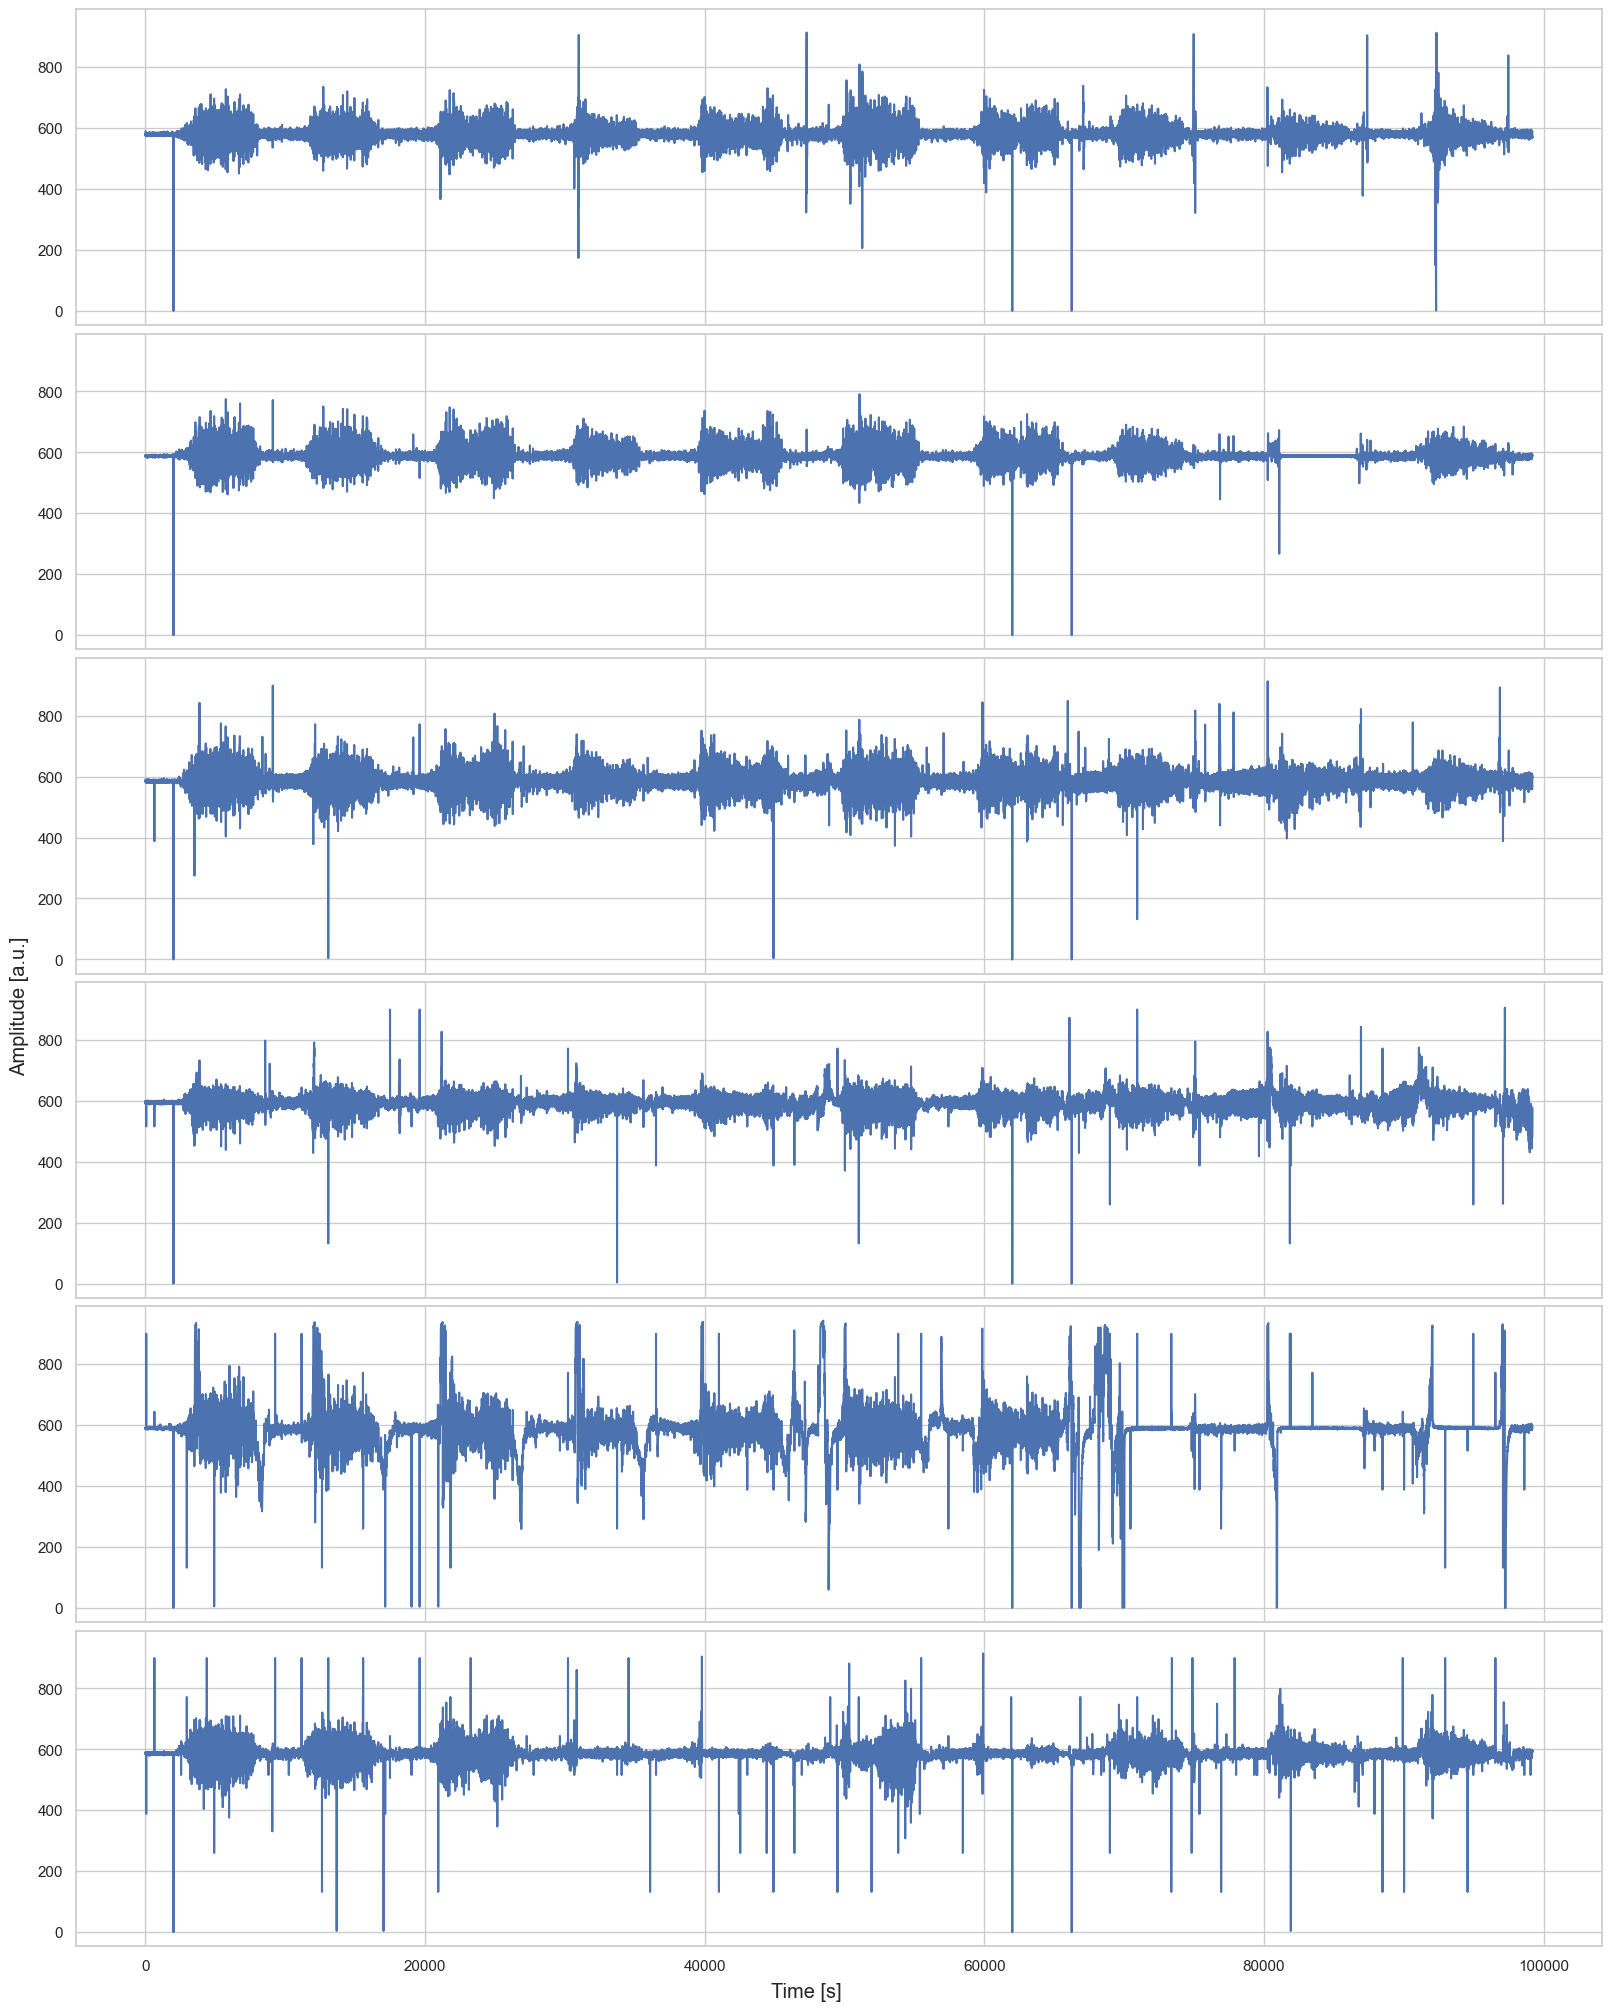

In [3]:
# samples = load_synthetic_signal(DATA_PATH, mvc=MVC, snr=SNR, seed=SEED)

import numpy as np
def standardize_channels(channel_array):
    # 假设 channel_array 的形状是 (num_channels, num_samples)
    standardized_array = np.zeros_like(channel_array)
    for i in range(channel_array.shape[0]):
        channel_data = channel_array[i]
        mean = np.mean(channel_data)
        std = np.std(channel_data)
        # 防止除以零
        if std != 0:
            standardized_array[i] = (channel_data - mean) / std
        else:
            standardized_array[i] = channel_data - mean
    return standardized_array

# 从文件读取数组
# loaded_emg = np.load('valid_emg.npy')
# loaded_emg = standardize_channels(loaded_emg)

# emg_df = pd.DataFrame({"Ch1": loaded_emg[0],
#                        "Ch2": loaded_emg[1],
#                        "Ch3": loaded_emg[2],
#                        "Ch4": loaded_emg[3],
#                        "Ch5": loaded_emg[4],
#                        "Ch6": loaded_emg[5],
#                        })
emg = emg_df

fs=FS
sig_len_s = emg.shape[0] / fs

emgkit.plotting.plot_signal(emg, fs, as_heatmap=False, fig_size=(16, 20), resolution=200)

In [4]:
# 遍历每个通道并计算均值和方差
for i, channel_data in enumerate(channel_array):
    channel_mean = np.mean(channel_data)
    channel_variance = np.var(channel_data)
    print(f"通道 {i+1} 的均值: {channel_mean:.5f}, 方差: {channel_variance:.5f}")
# 进行中心化处理
channel_array = channel_array - np.mean(channel_array, axis=1, keepdims=True)

通道 1 的均值: 580.26064, 方差: 728.79883
通道 2 的均值: 588.08686, 方差: 594.74899
通道 3 的均值: 584.92037, 方差: 973.73323
通道 4 的均值: 593.45593, 方差: 756.57358
通道 5 的均值: 586.64437, 方差: 6022.89234
通道 6 的均值: 586.04386, 方差: 653.34348


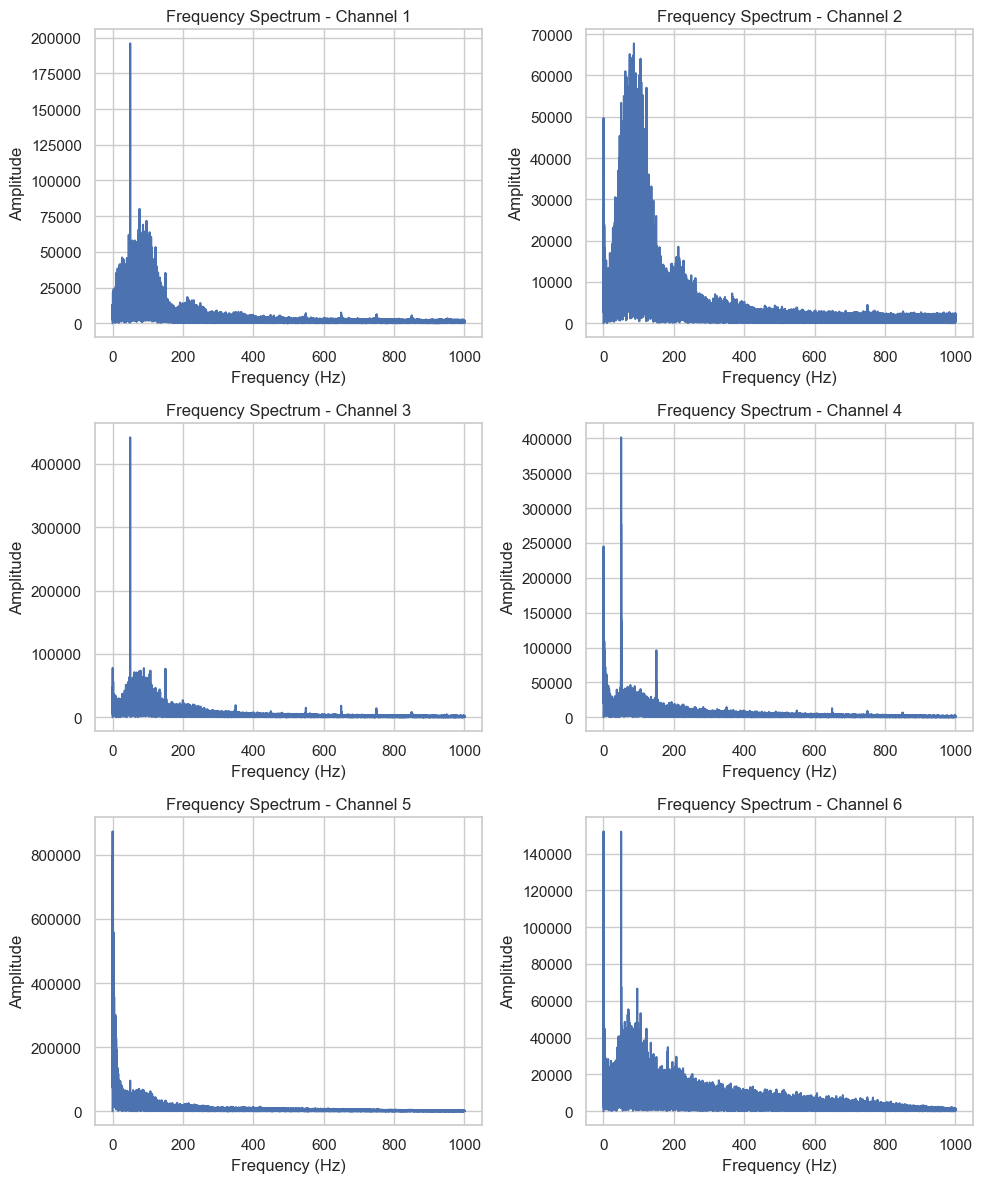

In [5]:
emgkit.preprocessing.plot_all_channels_frequency_spectrum(channel_array, fs=FS,figsize= (10,4))

In [6]:
channel_array_removed_artifacts = np.zeros_like(channel_array)
import numpy as np
from scipy.signal import butter, filtfilt

def bandpass_filter(data, lowcut, highcut, fs, order=4):
    """
    Apply a Butterworth bandpass filter to the EMG signal.

    Parameters:
    - data: The EMG signal data (1D numpy array).
    - lowcut: The low cutoff frequency (in Hz).
    - highcut: The high cutoff frequency (in Hz).
    - fs: The sampling rate of the signal (in Hz).
    - order: The order of the filter.

    Returns:
    - Filtered EMG signal (1D numpy array).
    """
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    y = filtfilt(b, a, data)
    return y

# 遍历每个通道
for i in range(channel_array.shape[0]):
    # 计算当前通道的均值和标准差
    mean = np.mean(channel_array[i])
    std = np.std(channel_array[i])
    # 设置阈值 (8倍标准差以上视为异常值)
    threshold = mean + 2 * std
    print(threshold)
    # 阈值检测 - 将超过阈值的值设为0
    # 注意：这里也可以将异常值替换为均值，或者使用其他合适的值
    channel_array_removed_artifacts[i] = np.where(np.abs(channel_array[i]) > threshold, mean, channel_array[i])


filter_channel_array = bandpass_filter(channel_array_removed_artifacts, lowcut=20, highcut=500, fs=FS, order=5)
# emgkit.plotting.plot_all_signal(
#     filter_channel_array,
#     fs=FS,
#     title=f"Preprocessed sEMG Signal({SUBJECT_TYPE})",
#     y_label="Amplitude [\u03BCV]",
#     fig_size=(20, 10),
# )


53.99254877945827
48.7749521517043
62.40939765207482
55.01176525083082
155.2145912797319
51.12116884443561


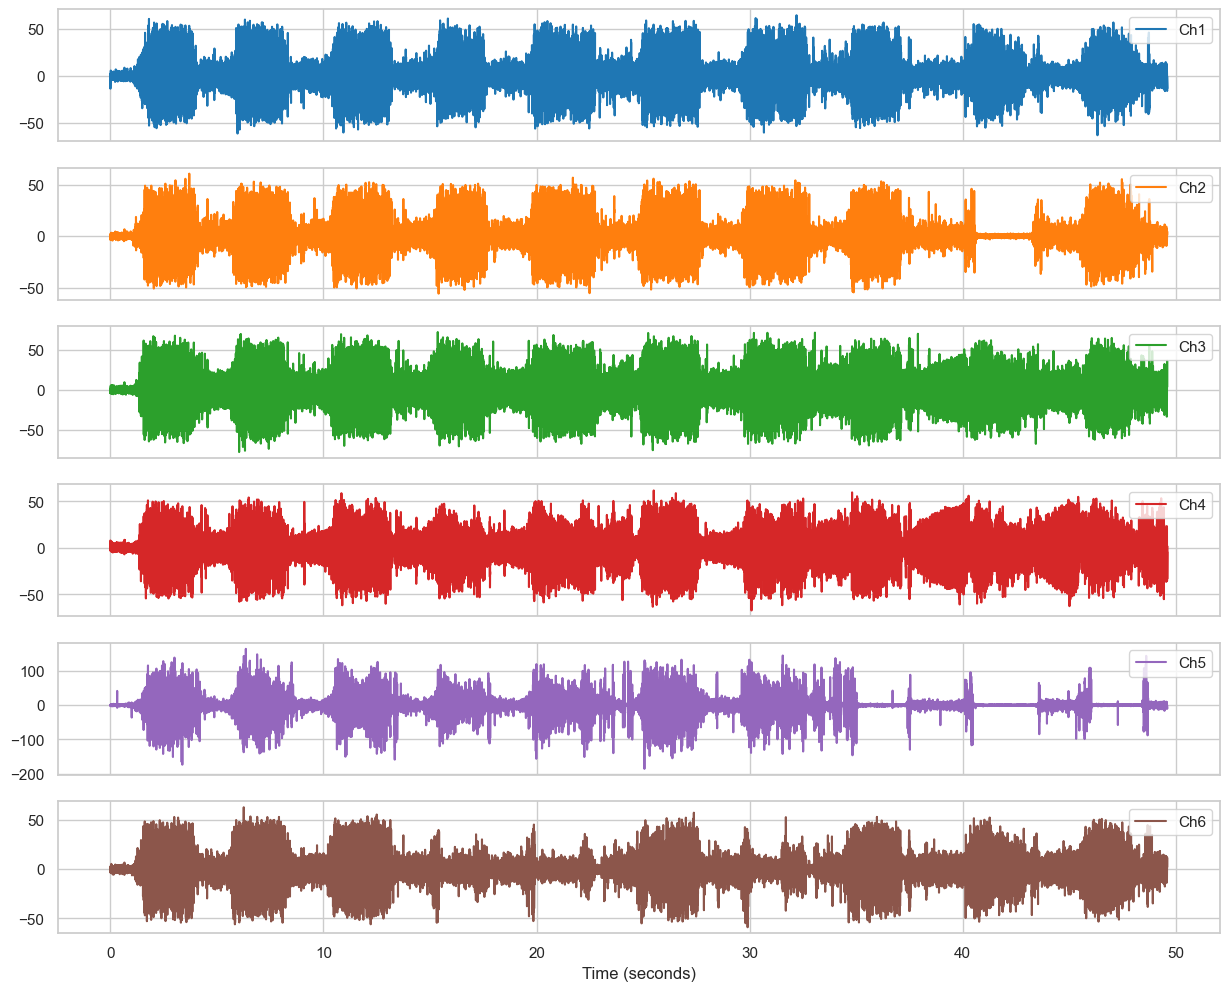

In [7]:
emg_df = pd.DataFrame({"Ch1": filter_channel_array[0],
                       "Ch2": filter_channel_array[1],
                       "Ch3": filter_channel_array[2],
                       "Ch4": filter_channel_array[3],
                       "Ch5": filter_channel_array[4],
                       "Ch6": filter_channel_array[5],
                       })

kwargs = {
    'title': f"Preprocessed sEMG Signal({SUBJECT_TYPE})",
    'y_label': "Amplitude [\u03BCV]",
    'fig_size': (8, 14)
}
# plt.figure(figsize=(8, 19))
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (15, 12)  # 设置默认图形大小
nk.signal_plot(emg_df, sampling_rate=2000,subplots=True)

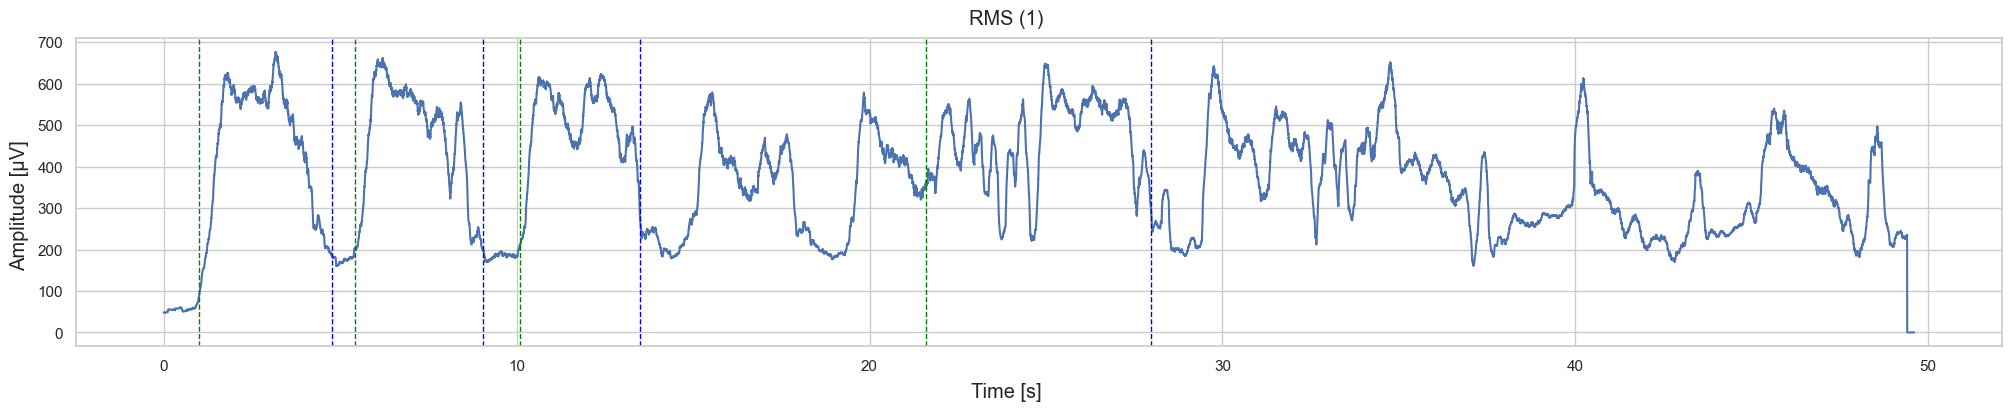

In [8]:
win_len = int(round(0.2 * FS))

emg_rms = np.zeros_like(channel_array_removed_artifacts)
for i in range(channel_array_removed_artifacts.shape[1] - win_len):
    cur_rms = (channel_array_removed_artifacts[:, i : i + win_len] ** 2).sum(axis=1)
    emg_rms[:, i] = np.sqrt(cur_rms)
emg_rms = np.mean(emg_rms, axis=0)

import numpy as np

def is_stable(signal_segment, stable_threshold):
    """Check if the signal segment is stable."""
    return np.var(signal_segment) < stable_threshold

def adjust_point(rms_signal, point, direction, stable_duration, stable_threshold):
    """
    Adjust the point backward or forward to find a stable region.
    direction should be -1 for backward search (start point), 
    and 1 for forward search (end point).
    """
    while point > 0 and point < len(rms_signal):
        segment_start = max(0, point - stable_duration) if direction == -1 else point
        segment_end = point if direction == -1 else min(len(rms_signal), point + stable_duration)
        if is_stable(rms_signal[segment_start:segment_end], stable_threshold):
            break
        point += direction
    return point

def detect_stimulations(rms_signal, threshold_factor=0, min_duration=2, FS=2000):
    mean_val = np.mean(rms_signal)
    std_val = np.std(rms_signal)
    
    
    threshold = mean_val + threshold_factor * std_val

    stable_threshold = std_val * 0.5  # Define a lower variance threshold to assess stability. 0.05
    stable_duration = FS // 4  # Number of samples that signal needs to be stable for half a second.
    
    stim_starts = []
    stim_ends = []
    
    is_stimulating = False
    stim_start_pos = None
    
    for i, value in enumerate(rms_signal):
        if value > threshold and not is_stimulating:
            # Potential start of stimulation
            is_stimulating = True
            stim_start_pos = i
        
        elif value < threshold and is_stimulating:
            # Potential end of stimulation
            if i - stim_start_pos >= (min_duration*FS):
                # Adjust the end point to ensure it's stable after the stimulation
                adjusted_end = adjust_point(rms_signal, i, 1, stable_duration, stable_threshold)
                # Adjust the start point to ensure it's stable before the stimulation
                adjusted_start = adjust_point(rms_signal, stim_start_pos, -1, stable_duration, stable_threshold)
                
                # Only add the points if they are different from the initial ones
                if adjusted_end != i or adjusted_start != stim_start_pos:
                    stim_starts.append(adjusted_start/FS)
                    stim_ends.append(adjusted_end/FS)
            is_stimulating = False
    
    # Check if a stimulation was ongoing at the end of the signal
    if is_stimulating and len(rms_signal) - stim_start_pos >= (min_duration*FS):
        adjusted_end = adjust_point(rms_signal, len(rms_signal), 1, stable_duration, stable_threshold)
        adjusted_start = adjust_point(rms_signal, stim_start_pos, -1, stable_duration, stable_threshold)
        
        if adjusted_end != len(rms_signal) or adjusted_start != stim_start_pos:
            stim_starts.append(adjusted_start/FS)
            stim_ends.append(adjusted_end/FS)
    
    return stim_starts, stim_ends
# detect_stimulations(emg_rms)


stimulation_starts, stimulation_ends = detect_stimulations(emg_rms)
# 绘制RMS信号和刺激的开始/结束点

f, ax = plt.subplots(figsize=(20, 4), layout="constrained")
f.suptitle(f"RMS ({SUBJECT_TYPE})")
f.supxlabel("Time [s]")
f.supylabel("Amplitude [\u03BCV]")

t = np.arange(channel_array_removed_artifacts.shape[1]) / FS
ax.plot(t, emg_rms)
# 在每个刺激的开始和结束点绘制垂直线
for start in stimulation_starts:
    ax.axvline(x=start, color='green', linestyle='--', linewidth=1, label='Start')
for end in stimulation_ends:
    ax.axvline(x=end, color='blue', linestyle='--', linewidth=1, label='End')
plt.show()

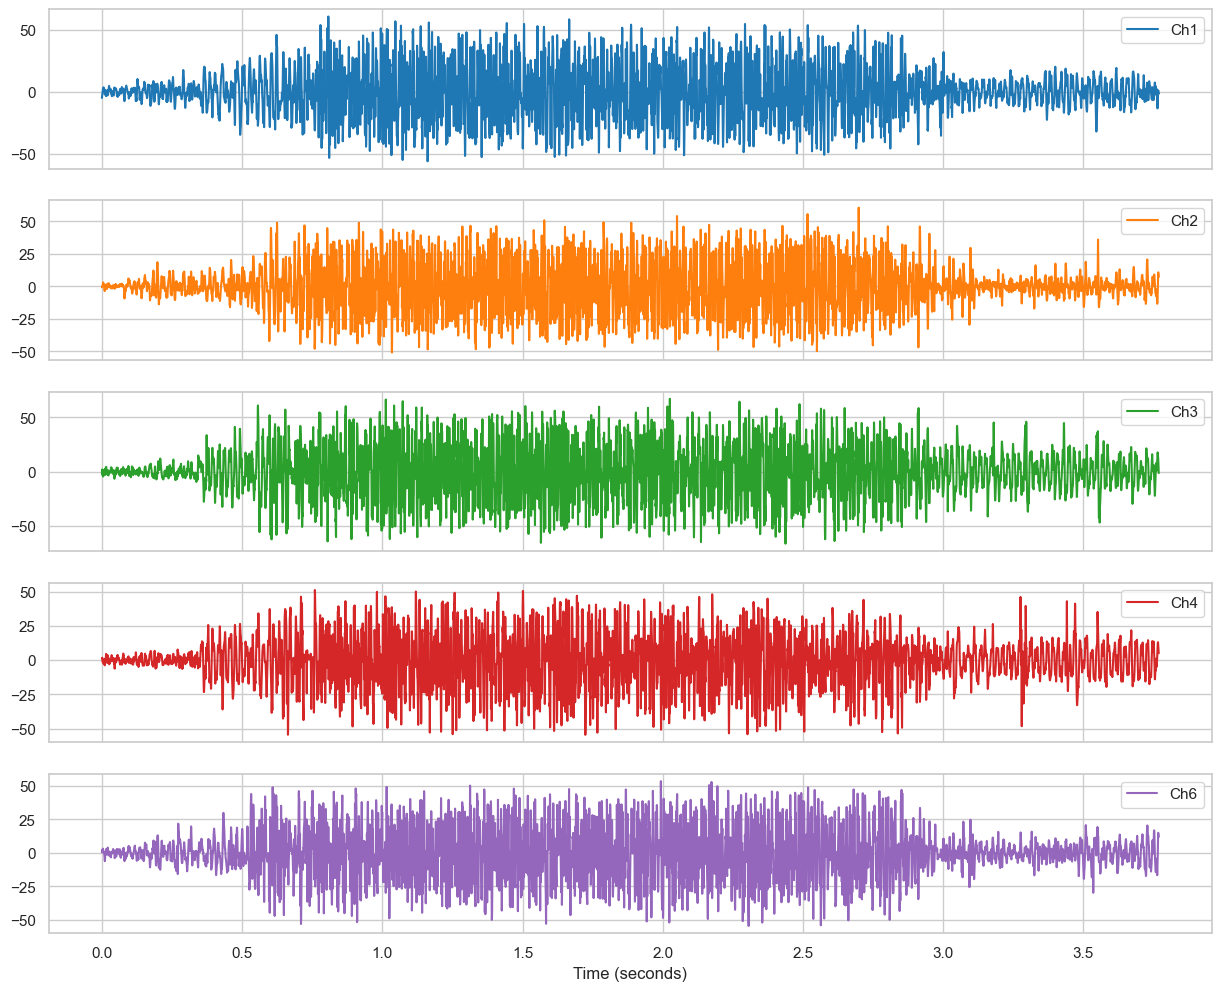

In [9]:
num_selected = 0
channel_array_removed_artifacts_backup = filter_channel_array
channel_array_removed_artifacts = channel_array_removed_artifacts_backup[:, int(stimulation_starts[num_selected]*FS):int(stimulation_ends[num_selected]*FS)]
emg_formal  = pd.DataFrame({
                            "Ch1": channel_array_removed_artifacts[0],
                            "Ch2": channel_array_removed_artifacts[1],
                            "Ch3": channel_array_removed_artifacts[2],
                            "Ch4": channel_array_removed_artifacts[3],
                            # "Ch5": channel_array_removed_artifacts[4],
                            "Ch6": channel_array_removed_artifacts[5],
                            })
emg_formal.shape
nk.signal_plot(emg_formal, sampling_rate=2000,subplots=True)

Instantiate the decomposition model and perform the MU extraction.

Plot the ICs spike trains.

In [10]:
import random
SEED=random.randint(0,9999)
SEED

5840

In [11]:
conv_bss = emgkit.decomposition.ConvBSS(
    fs=2000,
    f_ext=30,
    sil_th=0.7,
    conv_th=1e-4, 
    max_iter=2000,
    seed=SEED,
    device=torch.device("cpu"),
)

ics, spikes_t = conv_bss.decompose_training(emg_formal)
ext_sig_len_s = ics.shape[0] / fs

INFO:root:Number of channels before extension: 5
INFO:root:Number of channels after extension: 150
INFO:root:----- IC 1 -----
INFO:root:FastICA converged after 32 iterations, the distance is: 7.309e-05.
INFO:root:CoV-ISI decreased from 49.82% to 49.01% after 1 steps.
INFO:root:CoV-ISI increased from 49.01% to 49.27% after 2 steps.
INFO:root:----- IC 2 -----
INFO:root:FastICA converged after 38 iterations, the distance is: 9.373e-05.
INFO:root:CoV-ISI increased from 50.24% to 52.23% after 1 steps.
INFO:root:----- IC 3 -----
INFO:root:FastICA converged after 71 iterations, the distance is: 9.684e-05.
INFO:root:CoV-ISI decreased from 149.52% to 41.63% after 1 steps.
INFO:root:CoV-ISI decreased from 41.63% to 41.59% after 2 steps.
INFO:root:CoV-ISI increased from 41.59% to 41.59% after 3 steps.
INFO:root:----- IC 4 -----
INFO:root:FastICA converged after 29 iterations, the distance is: 9.730e-05.
INFO:root:CoV-ISI decreased from 151.60% to 41.40% after 1 steps.
INFO:root:CoV-ISI decreased 

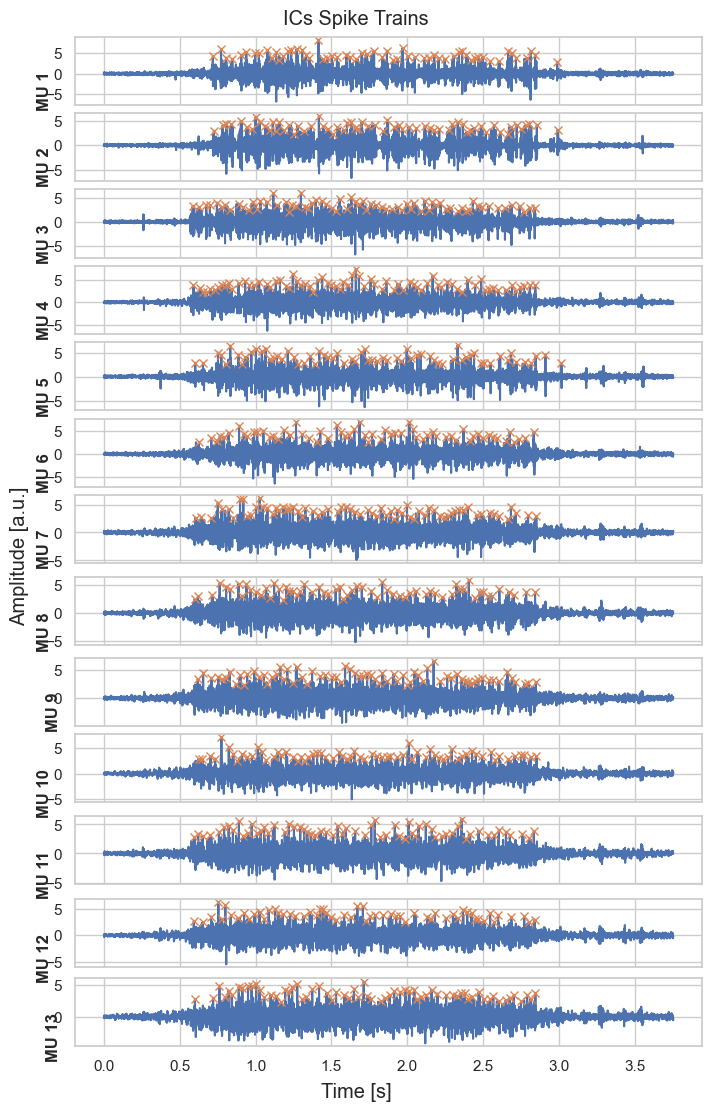

In [12]:
emgkit.plotting.plot_ic_spikes(ics, spikes_t, fig_size=(7, 11))

Display the raster plot.

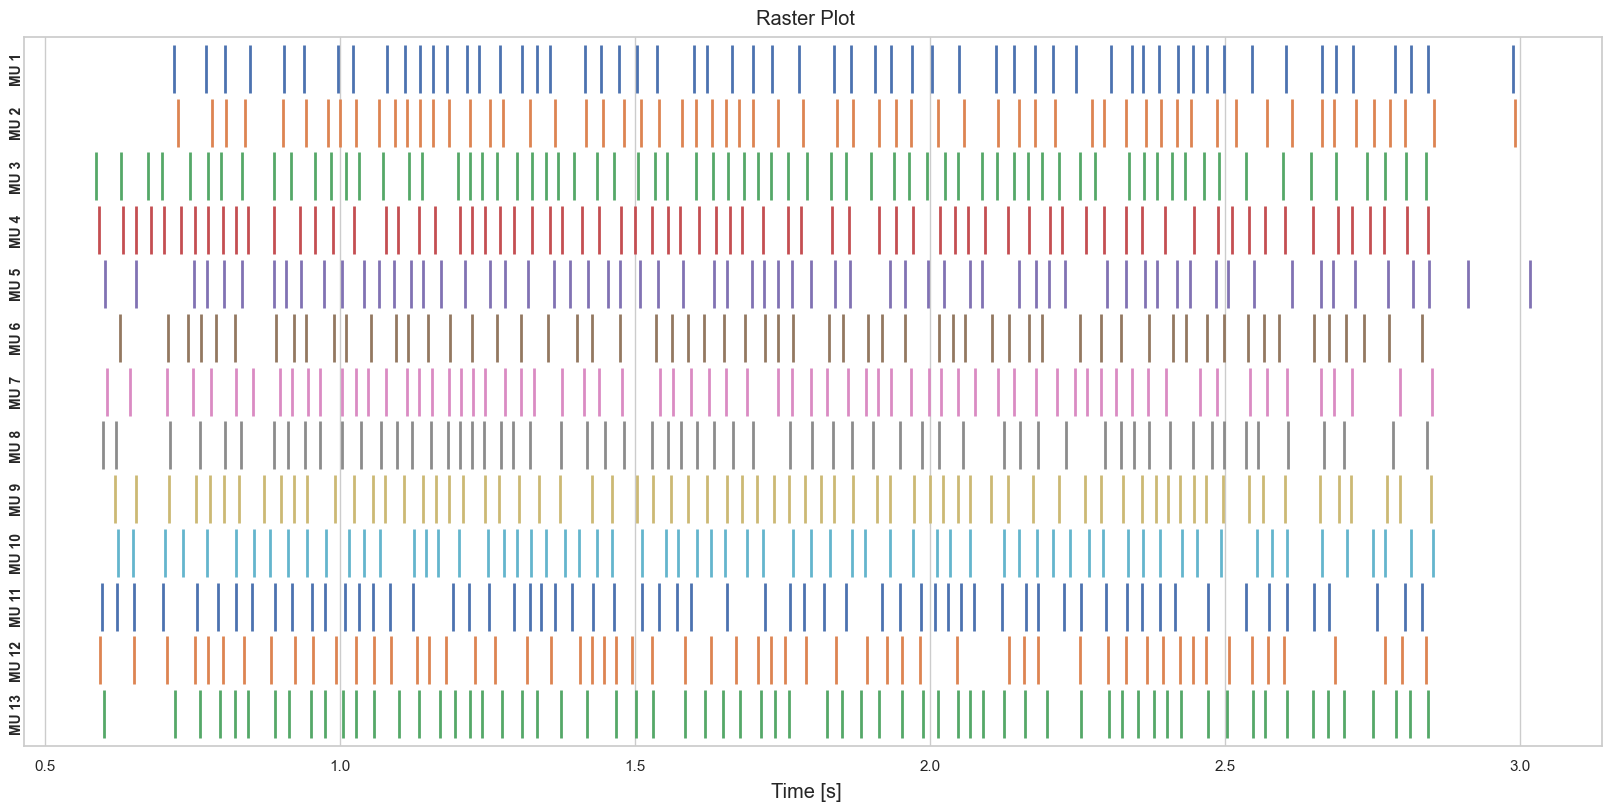

In [13]:
emgkit.plotting.raster_plot(spikes_t, fig_size=(16, 8))

Display the discharge rate.

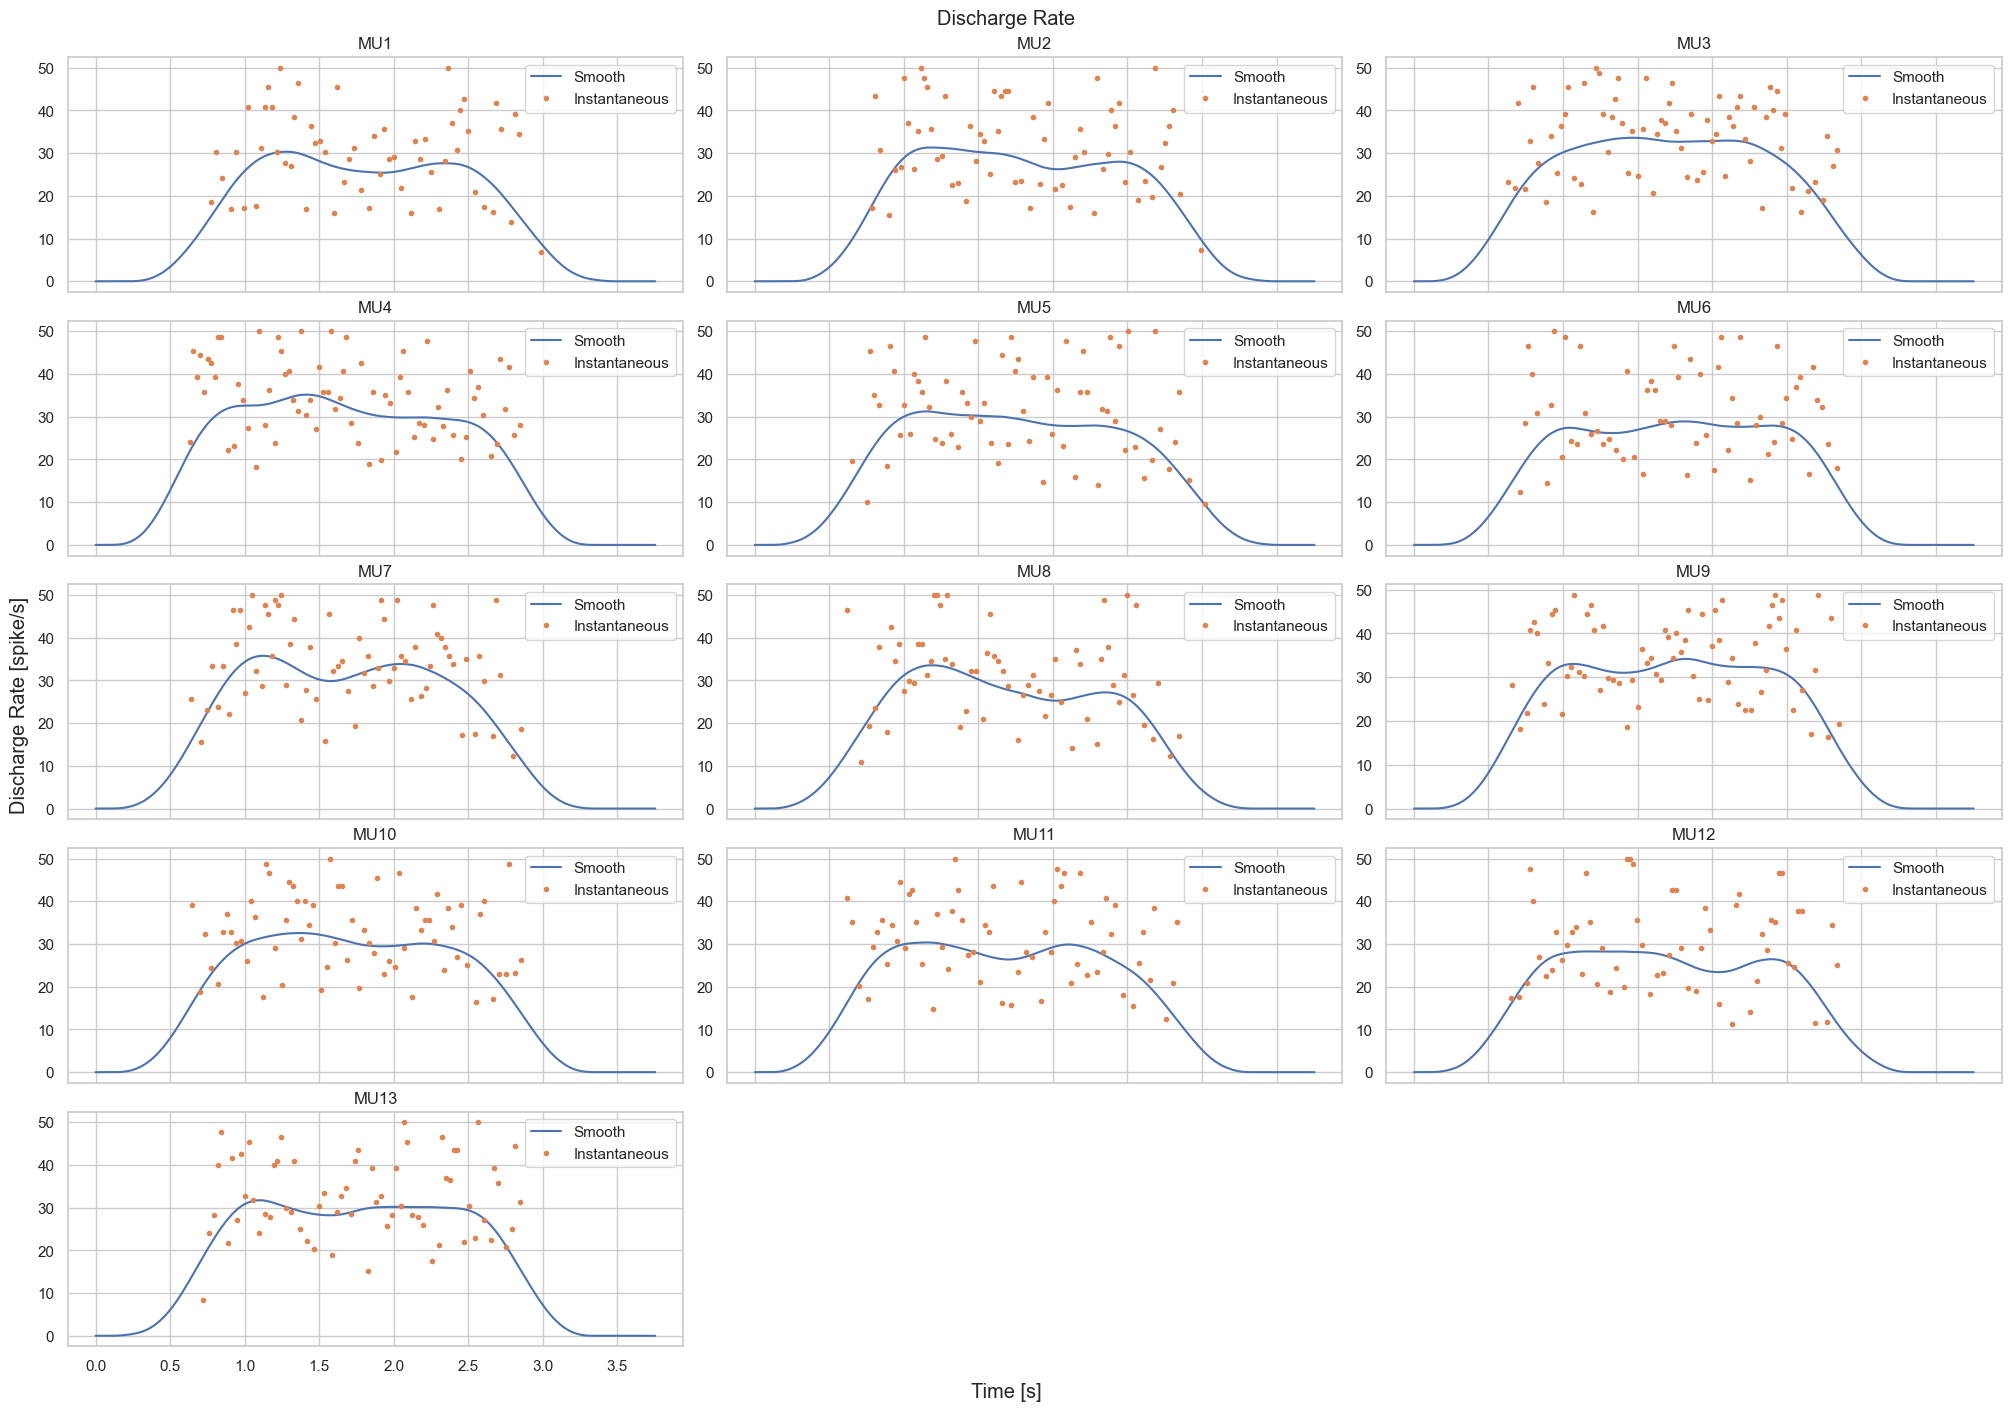

In [14]:
emgkit.plotting.plot_discharges(spikes_t, ext_sig_len_s, fs, fig_size=(20, 14))

Compute the waveforms and plot them.

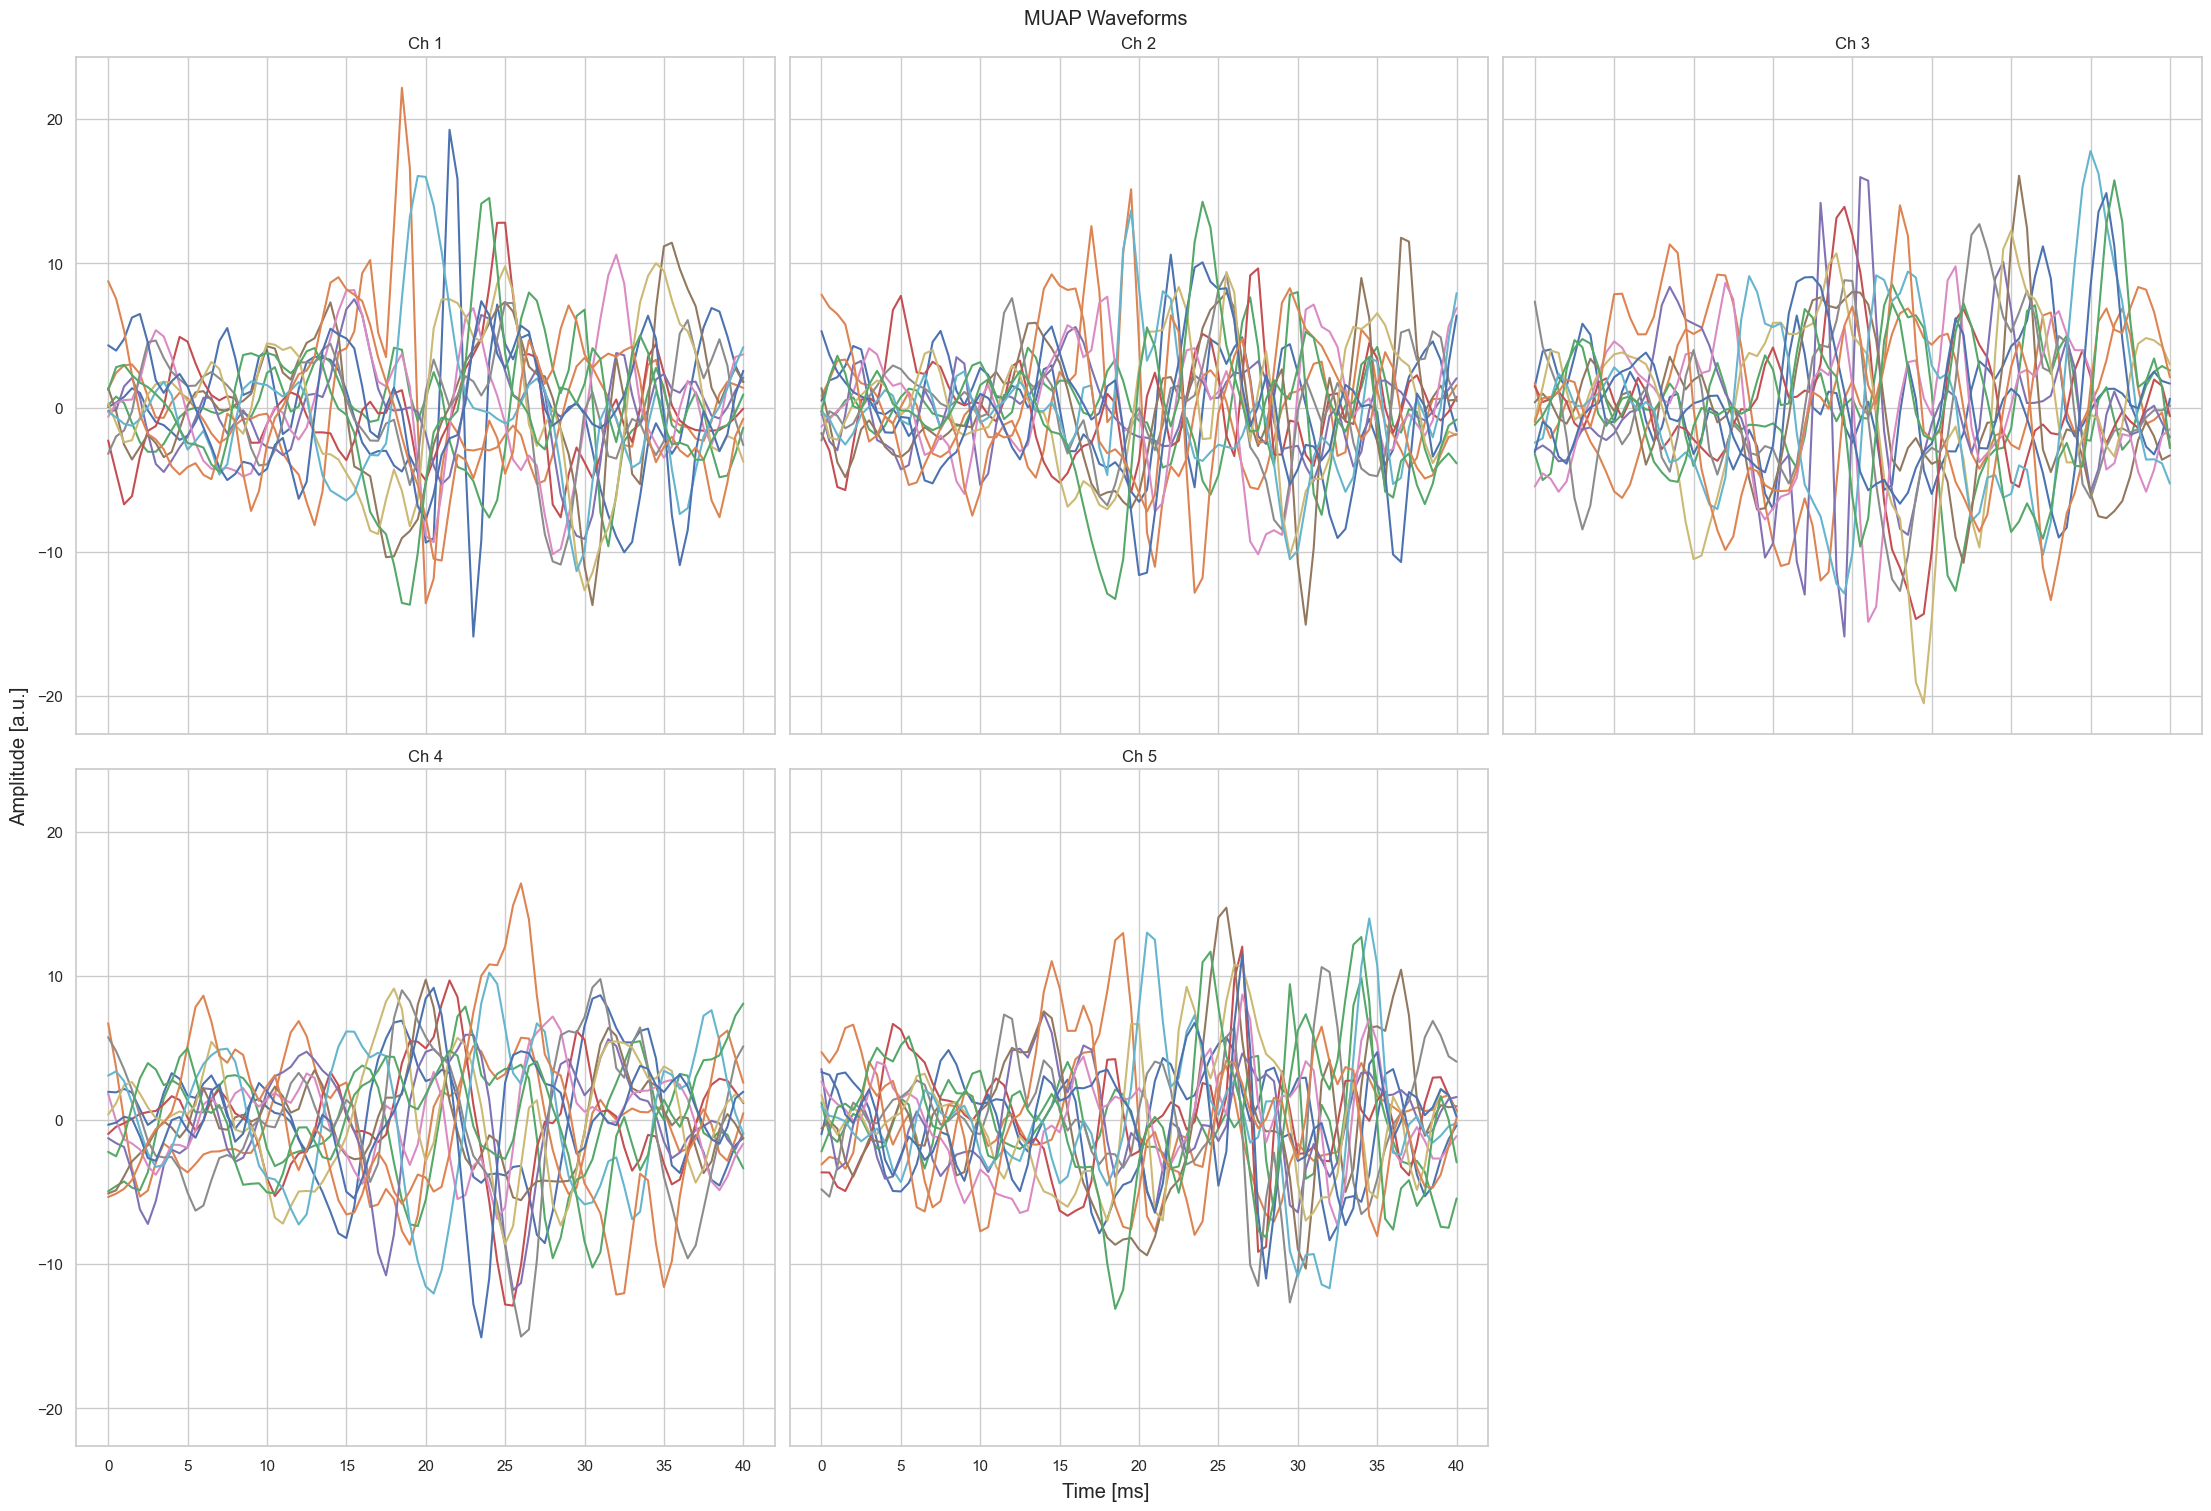

In [16]:
wfs = emgkit.utils.compute_waveforms(emg_formal, spikes_t, wf_radius_ms=20.0, fs=fs)

emgkit.plotting.plot_waveforms(wfs, fs=fs,n_cols=3, fig_size=(22, 15))

Compare the extracted MUs with the ground truth.